# 1. Building powerful image classification models using very little data


## 1.1 A Small ConvNet 
As a baseline

In [1]:
'''This script goes along the blog post
"Building powerful image classification models using very little data"
from blog.keras.io.
It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs
So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```
'''

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '/media/ubuntu16/Documents/datasets/dogs-vs-cats-2000/train/'
validation_data_dir = '/media/ubuntu16/Documents/datasets/dogs-vs-cats-2000/validation'

nb_train_samples = 2000
nb_validation_samples = 800

epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

# generate batches of image data (and their labels) directly from our jpgs in their respective folders.
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

#model.save_weights('first_try.h5')

Using TensorFlow backend.


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50
125/125 [==============================] - 36s 290ms/step - loss: 0.7184 - acc: 0.5310 - val_loss: 0.6793 - val_acc: 0.6275
Epoch 2/50
125/125 [==============================] - 13s 105ms/step - loss: 0.6826 - acc: 0.5800 - val_loss: 0.6432 - val_acc: 0.6850
Epoch 3/50
125/125 [==============================] - 13s 105ms/step - loss: 0.6429 - acc: 0.6560 - val_loss: 0.5982 - val_acc: 0.6675
Epoch 4/50
125/125 [==============================] - 13s 105ms/step - loss: 0.6207 - acc: 0.6625 - val_loss: 0.5775 - val_acc: 0.7350
Epoch 5/50
125/125 [==============================] - 13s 108ms/step - loss: 0.5915 - acc: 0.7015 - val_loss: 0.5977 - val_acc: 0.6613
Epoch 6/50
125/125 [==============================] - 14s 110ms/step - loss: 0.5768 - acc: 0.7030 - val_loss: 0.5734 - val_acc: 0.6963
Epoch 7/50
125/125 [==============================] - 14s 109ms/step - loss: 0.5642 - acc: 0.7185 - val_los

## 1.2 Fine-tuning a pre-trained network

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import optimizers


# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '/media/ubuntu16/Documents/datasets/dogs-vs-cats-2000/train/'
validation_data_dir = '/media/ubuntu16/Documents/datasets/dogs-vs-cats-2000/validation/'

nb_train_samples = 2000
nb_validation_samples = 800

epochs = 50
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

# generate batches of image data (and their labels) directly from our jpgs in their respective folders.
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

# 构建不带分类器的预训练模型
# 因不包含top层，输入维度不用固定
base_model = VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

# 
x = base_model.output 
x = GlobalAveragePooling2D()(x)
#x = Flatten(input_shape=base_model.output_shape[1:])(x)

# 添加全连接层
x = Dense(256, activation='relu', name='dense_1')(x)

# 添加分类器 (二分类使用sigmoid, 多分类使用softmoax)
predictions = Dense(1, activation='sigmoid', name='output')(x)

# 构建完整模型
model = Model(input=base_model.input, output=predictions)

# 首先，锁住预训练好的卷积层， 仅训练顶部的两层
for i, layer in enumerate(base_model.layers):
    layer.trainable = False
    print(i,layer.name)
    
# 编译模型，一定要在锁层以后操作
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

# 在新的数据集上训练
hist_top = model.fit_generator(train_generator,
                               samples_per_epoch=nb_train_samples//batch_size,
                               epochs = epochs,
                               verbose = 1,
                               validation_data = validation_generator,
                               validation_steps= nb_validation_samples//batch_size)


# 微调VGG16部分卷积层
# 通过查看各层编号和名字，锁住前15层，训练之后的层
# 不能微调所有层，因为整个网络的表示能力过于强大，很容易过拟合
for layer in model.layers[:15]:
    layer.trainable = False

for layer in model.layers[15:]:
    layer.trainable = True
    
# 重新编译模型，使设置生效 （注意使用sgd）
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

# fine-tune the model
hist_tune = model.fit_generator(train_generator,
                               samples_per_epoch=nb_train_samples//batch_size,
                               epochs = epochs,
                               verbose = 1,
                               validation_data = validation_generator,
                               validation_steps= nb_validation_samples//batch_size)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Model loaded.
0 input_11
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
________________________

/home/ubuntu16/venv/lib/python3.5/site-packages/ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`
/home/ubuntu16/venv/lib/python3.5/site-packages/ipykernel_launcher.py:81: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_steps=50, epochs=50, validation_data=<keras_pre..., steps_per_epoch=7, verbose=1)`


7/7 [==============================] - 3s 462ms/step - loss: 0.8413 - acc: 0.4732 - val_loss: 0.6118 - val_acc: 0.7312
Epoch 2/50
7/7 [==============================] - 3s 414ms/step - loss: 0.5815 - acc: 0.7321 - val_loss: 0.5582 - val_acc: 0.6787
Epoch 3/50
7/7 [==============================] - 3s 406ms/step - loss: 0.6145 - acc: 0.6339 - val_loss: 0.4961 - val_acc: 0.8100
Epoch 4/50
7/7 [==============================] - 3s 403ms/step - loss: 0.5114 - acc: 0.7321 - val_loss: 0.6042 - val_acc: 0.6362
Epoch 5/50
7/7 [==============================] - 3s 412ms/step - loss: 0.5888 - acc: 0.6786 - val_loss: 0.4453 - val_acc: 0.8163
Epoch 6/50
7/7 [==============================] - 3s 415ms/step - loss: 0.4803 - acc: 0.7679 - val_loss: 0.4300 - val_acc: 0.8425
Epoch 7/50
7/7 [==============================] - 3s 422ms/step - loss: 0.5518 - acc: 0.7768 - val_loss: 0.5862 - val_acc: 0.6663
Epoch 8/50
7/7 [==============================] - 3s 411ms/step - loss: 0.4959 - acc: 0.7857 - val_lo

Epoch 1/50


/home/ubuntu16/venv/lib/python3.5/site-packages/ipykernel_launcher.py:107: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_steps=50, epochs=50, validation_data=<keras_pre..., steps_per_epoch=7, verbose=1)`


7/7 [==============================] - 4s 504ms/step - loss: 0.2183 - acc: 0.9286 - val_loss: 0.2546 - val_acc: 0.8912
Epoch 2/50
7/7 [==============================] - 3s 440ms/step - loss: 0.3459 - acc: 0.8036 - val_loss: 0.2540 - val_acc: 0.8925
Epoch 3/50
7/7 [==============================] - 3s 422ms/step - loss: 0.2926 - acc: 0.8750 - val_loss: 0.2454 - val_acc: 0.8950
Epoch 4/50
7/7 [==============================] - 3s 422ms/step - loss: 0.3393 - acc: 0.8482 - val_loss: 0.2551 - val_acc: 0.8875
Epoch 5/50
7/7 [==============================] - 3s 431ms/step - loss: 0.2509 - acc: 0.9018 - val_loss: 0.2420 - val_acc: 0.9000
Epoch 6/50
7/7 [==============================] - 3s 444ms/step - loss: 0.2676 - acc: 0.8839 - val_loss: 0.2445 - val_acc: 0.8912
Epoch 7/50
7/7 [==============================] - 3s 423ms/step - loss: 0.2558 - acc: 0.8929 - val_loss: 0.2746 - val_acc: 0.8712
Epoch 8/50
7/7 [==============================] - 3s 444ms/step - loss: 0.2572 - acc: 0.8571 - val_lo

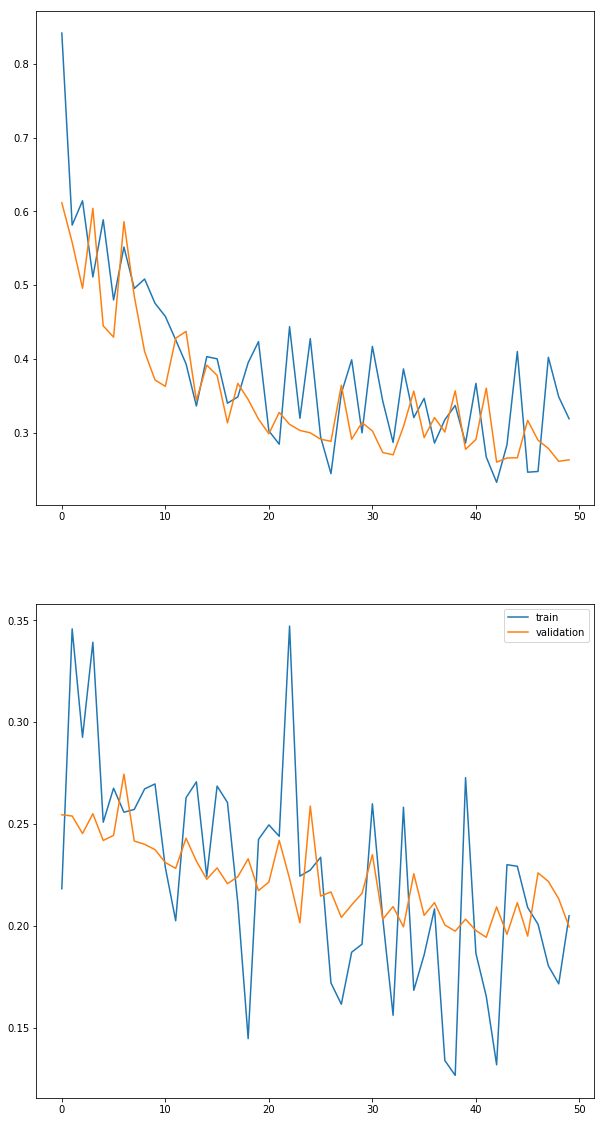

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1, figsize=(10, 20))
axes[0].plot(hist_top.history['loss'], label='train')
axes[0].plot(hist_top.history['val_loss'], label='validation')

axes[1].plot(hist_tune.history['loss'], label='train')
axes[1].plot(hist_tune.history['val_loss'], label='validation')

plt.legend()
plt.show()


In [1]:
from keras.applications.vgg16 import VGG16 
base_model = VGG16(weights='imagenet', include_top=False)

print(len(base_model.layers))
print()
print(base_model.inputs) # 模型输入张量的列表，可能由多个输入
print(base_model.input)
print()
print(base_model.outputs) # 模型输入张量的列表，可能由多个输入
print(base_model.output)
print()
print(base_model.input_shape)
print(base_model.output_shape)
print()
print(base_model.summary())

Using TensorFlow backend.


19

[<tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>]
Tensor("input_1:0", shape=(?, ?, ?, 3), dtype=float32)

[<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, ?, ?, 512) dtype=float32>]
Tensor("block5_pool/MaxPool:0", shape=(?, ?, ?, 512), dtype=float32)

(None, None, None, 3)
(None, None, None, 512)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (N

In [13]:
base_model.get_config()

{'input_layers': [['input_1', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'name': 'input_1',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_1'},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'filters': 64,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'distribution': 'uniform',
      'mode': 'fan_avg',
      'scale': 1.0,
      'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (3, 3),
    'name': 'block1_conv1',
    'padding': 'same',
    'strides': (1, 1),
    'trainable': True,
    'use_bias': True},
   'inbound_nodes': [[['input_1', 0, 0, {}]]],
   'name': 'block